In [46]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [47]:
def read_topology(filepath):
    G = nx.Graph()
    with open(filepath, 'r') as file:
        nodes_section = True  # Start reading the nodes section
        for line in file:
            if line.startswith('Edges:'):
                nodes_section = False  # Switch to reading the edges section
                continue

            if nodes_section:
                if line.strip() and line.strip() != "Nodes:":
                    G.add_node(line.strip())
            else:
                parts = line.strip().split()
                if len(parts) == 3:
                    G.add_edge(parts[0], parts[1], weight=int(parts[2]))
    return G

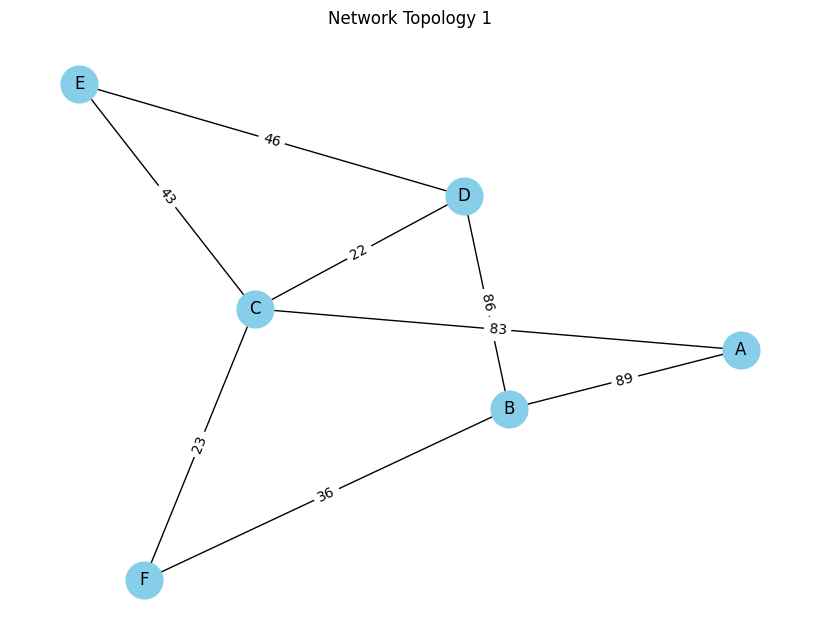

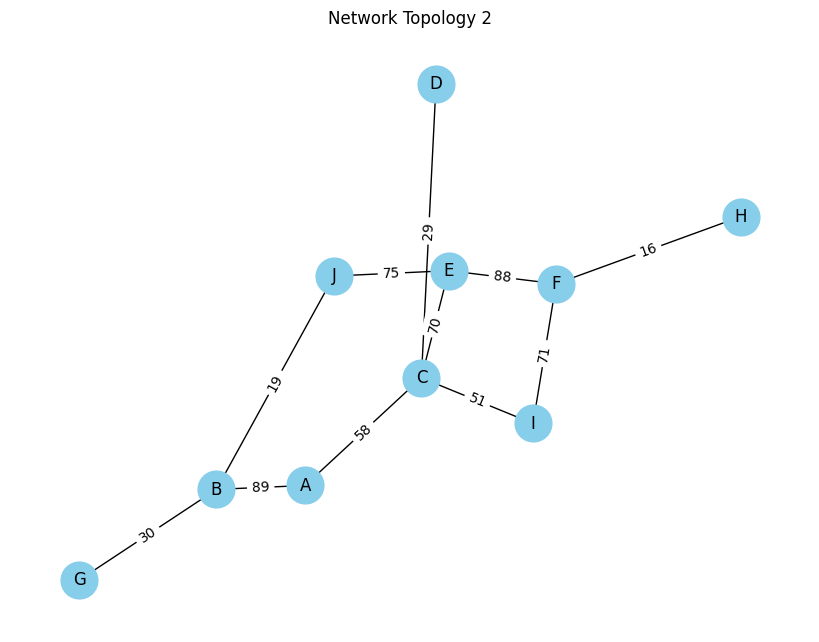

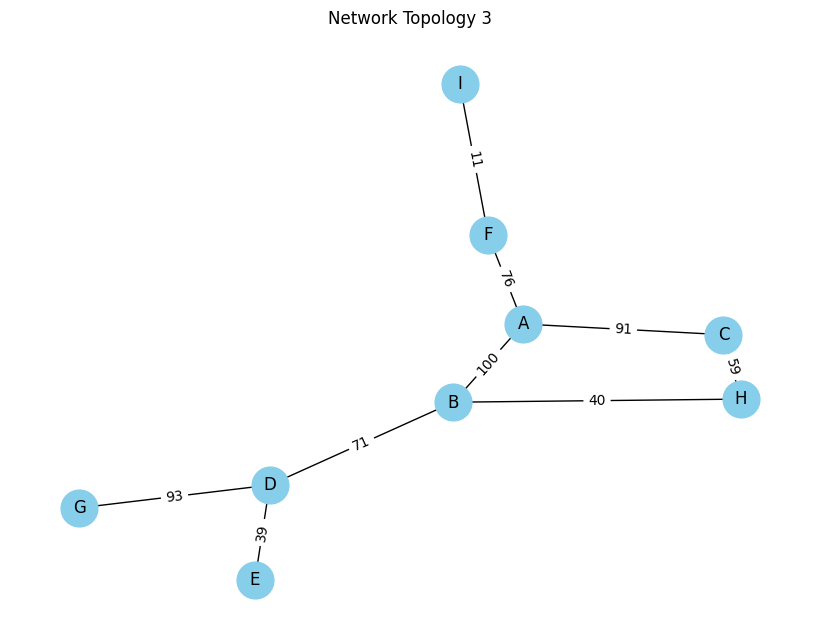

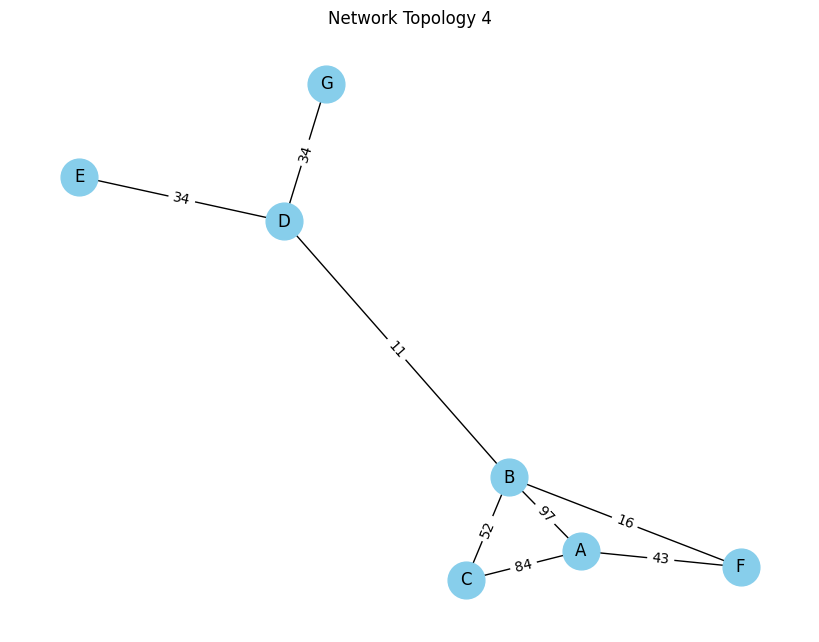

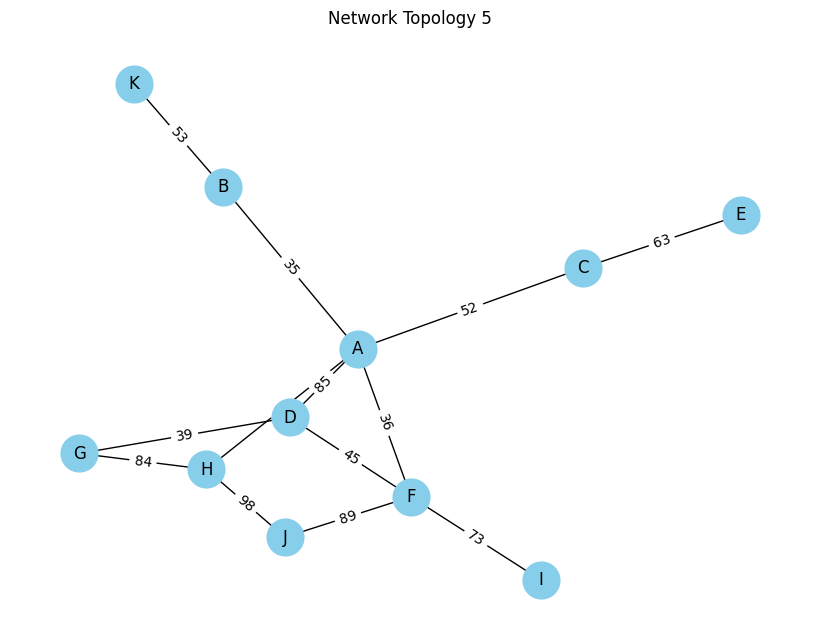

In [48]:
filepaths = [
    "M:/Group Project/ManojTopologies/topology_1.txt",
    "M:/Group Project/ManojTopologies/topology_2.txt",
    "M:/Group Project/ManojTopologies/topology_3.txt",
    "M:/Group Project/ManojTopologies/topology_4.txt",
    "M:/Group Project/ManojTopologies/topology_5.txt",    
]

for i, filepath in enumerate(filepaths, start=1):
    G = read_topology(filepath)
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})
    plt.title(f'Network Topology {i}')
    plt.show()

In [55]:
topologies_results = {}

for i, filepath in enumerate(filepaths, start=1):
    # Read the topology from the file
    G = read_topology(filepath)
    
    # Assign an ID to the topology
    topology_id = f"Topology_{i}"
    
    # Store the topology in the dictionary with its ID
    topologies_results[topology_id] = {}
    
    ## Select Middle Points
    betweenness_centrality = nx.betweenness_centrality(G)
    # Sorting nodes by betweenness centrality
    middle_points = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)

    specified_middle_points = middle_points[:5]  # Dynamically select top 5 nodes as middle points
    ###print(f"Middle points for {topology_id} based on betweenness centrality:", specified_middle_points)
    
     # Routing flows through the network for the current topology and flow demands
    def route_flows_sequentially_through_network(G, flow_demands, middle_points):
        results = {}

        # Function to route a single flow through a sequence of middle points
        def route_flow(flow, middle_points_sequence):
            source, target, demand = flow
            path = [source]  # Start path with the source

            # Attempt to route through each middle point in sequence
            for mp in middle_points_sequence:
                if mp not in path:  # Avoid looping back to a middle point
                    try:
                        part_path = nx.shortest_path(G, path[-1], mp)[1:]  # Path to next middle point
                        path.extend(part_path)
                    except nx.NetworkXNoPath:
                        return None  # Path not possible through this middle point

            # Complete path to the target
            if target != path[-1]:
                try:
                    path.extend(nx.shortest_path(G, path[-1], target)[1:])
                except nx.NetworkXNoPath:
                    return None

            # Check if the path can support the flow demand
            if all(G[path[i]][path[i+1]]['weight'] >= demand for i in range(len(path)-1)):
                return path
            else:
                return None

        # Sequentially include middle points and attempt routing
        for i in range(1, len(middle_points) + 1):
            if i > 1:
                middle_points_sequence = random.sample(middle_points, i)  # Randomly select i middle points
            else:
                middle_points_sequence = middle_points[:i]  # Keep the first element for i=1 to avoid random.sample error
            
            successes = 0
            detailed_paths = []  # Initialize detailed_paths here
            for flow in flow_demands:
                path = route_flow(flow, middle_points_sequence)
                if path:
                    successes += 1
                    detailed_paths.append((flow, path))
            #results[i] = {'success_count': successes, 'paths': detailed_paths}
            results[i] = {'success_count': successes}
        #print(results)
        return results

    # Generate random flow demands for the current topology
    def generate_flow_demand(nodes):
        source = random.choice(nodes)
        target = random.choice(nodes)
        while source == target:
            target = random.choice(nodes)
        demand_size = random.randint(10, 50)
        return source, target, demand_size

    nodes = list(G.nodes)
    # Generating random flow demands
    flow_demands = [generate_flow_demand(nodes) for _ in range(5)]
    ###print("Flow demands for", topology_id, ":", flow_demands)

    # Calculate routing results with sequential middle point inclusion
    routing_results = route_flows_sequentially_through_network(G, flow_demands, specified_middle_points)
    topologies_results[topology_id] = routing_results
print(topologies_results)

# Display the results
###for topology_id, result in topologies_results.items():
   ### print(f"{topology_id}:")
   ### for num_middle_points, result_detail in result.items():
       ### print(f" {num_middle_points} middle point(s): {result_detail['success_count']} successful demand flow(s)")
       ### for flow, path in result_detail['paths']:
         ###   print(f"  Flow {flow} successfully routed through path: {path}")

{'Topology_1': {1: {'success_count': 4}, 2: {'success_count': 5}, 3: {'success_count': 4}, 4: {'success_count': 4}, 5: {'success_count': 3}}, 'Topology_2': {1: {'success_count': 3}, 2: {'success_count': 3}, 3: {'success_count': 3}, 4: {'success_count': 1}, 5: {'success_count': 1}}, 'Topology_3': {1: {'success_count': 5}, 2: {'success_count': 5}, 3: {'success_count': 5}, 4: {'success_count': 5}, 5: {'success_count': 4}}, 'Topology_4': {1: {'success_count': 1}, 2: {'success_count': 0}, 3: {'success_count': 0}, 4: {'success_count': 0}, 5: {'success_count': 0}}, 'Topology_5': {1: {'success_count': 4}, 2: {'success_count': 3}, 3: {'success_count': 3}, 4: {'success_count': 3}, 5: {'success_count': 3}}}
